# The `cascade` module of the `cascapy` package

Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cascapy.constants import *
from cascapy.intrinsic import *
from cascapy.cascade import *

## 1- Reading the results of the Monte Carlo simulation
Any prediction for the cascade emission must start by reading the output file of a Monte Carlo simulation. This is done with the `EventCatalog` class. According to its name, an instance of this class is a catalog of many detections events which contains all (or a selection of the) events in the simulation results. 


### 1a- Check simulation information:
When only general information on a simulation are seeked (e.g. parameters used for this simulation), reading the entire data file is long and not mandatory. In such case, it is possible to add the `info_only=True` keyword. Then, only the file header are read.

In [2]:
filename = "particles.csc"

In [3]:
ec = EventCatalog(filename=filename,info_only=True)
ec.info()


Reading: particles.csc...
Done
SIMULATION SETUP:
   redshift      = 0.4245
   nature        = 0
   number        = 100000
   E00min (MeV)  = 1.00e+00
   E00max (TeV)  = 1.00e+02
   Gamma00       = 0.75
   eta_mfp       = 0.01
   Ewth (MeV)    = 1.00e-01
   Eeth (MeV)    = 5.00e+03
   Neth          = 10
   genmax        = 15
   Nthreads      = 10.0
   tmax          = 1.0000e+06
   B             = 1e-17
   lambdaB       = 3.086e+27
   nBseed        = 100
PREPROCESSING OPTIONS:
   OPENMP              


### 1b- Read full data, and apply some selection:
In any other case, the full data file must be read. This process can last several seconds for large data files.
Depending on the goals, this step is also used to perform selection on the events. For instance keep only photon
- in a given time delay range
- in a given energy range
- in a given observation angle range
- etc

A more severe selection produces a smaller catalog which is ligher and much faster to process in the next steps. Hences, it is always a good idea to use severe criteria. However, they must remain consistent with the aims of the analysis.

In [4]:
# Read file, and apply selection, and display info with the chatter flag
cat = EventCatalog(filename=filename,emin=10*GeV,emax=10*TeV,chatter=True)

# Display some information computed in the new sample.
print("")
print(f"Max energy (TeV): {np.max(cat.data['energy'])/TeV:.2e}")
print(f"Number of numerical particles: {cat.params['npart']:d}")
print(f"Number of physical particles:  {np.sum(cat.data['weight']):.2e}")


Reading: particles.csc...
Done

Max energy (TeV): 2.59e+00
Number of numerical particles: 112099
Number of physical particles:  3.60e+03


## 2- Apply a model for the intrinsic emission and bin data
All raw events in a `EventCatalog`instance are weighted and have properties according to some default setup. For instance: 
- their time is delay time (not an observation time)
- their weight assumes a flat spectrum and an default normalisation
- etc...

For any model describing a source of given properties, these raw events must be further processed. Also, most results must be binned to be interpreted. These two points are achieved with the `BinnedData` class. An instance of this class contains data binned in various quantities (depending on the passed parameters), and corresponding to the given source model.
For instance, in such an instance, the time is now the observation time (as opposed to a time delay).

The following steps allows to compare the cascade emission of two different intrinsic models for the same simulation.

### 2a- Read the raw data

In [5]:
# Define simulation to use
z = 0.4245
B = 1.e-17
file = 'particles.csc'


# Define energy bins
emin,emax,nbin = 0.1*GeV,10*TeV,100
e,eb,de = grid(emin,emax,nbin,log=True)

# Define time range
tmin, tmax = 62., 62+30*day

# Read raw event catalog and apply some selections
rawdata = EventCatalog(filename=file,gen=[0,1,2,3],emin=emin,emax=emax,
                tmax=tmax,thdmax=0.1*degree,chatter=False)

### 2b- Define a first model with a powerlaw time decay
At this step, the bin definition for all parameters are passed as instantiation arguments.

In [6]:
# Model1 is the reference model for GRB190114C 
model1 = GRB190114C
bd1 = BinnedData(rawdata,ebins=eb,tbins=[tmin,tmax],gbins=[0,1,2,3],smodel=model1)


Binning Data
This might take a minute or so...
Done


### 2c- Define a second model with a pulse in time

In [7]:
# Define unnormalized model
emodel = GRB190114C.emodel
tmodel = PulseTimeModel()
amodel = DiskAngularModel(th_jet = 10*degree, th_obs=0.0)
model2 = SourceModel(tmodel=tmodel,emodel=emodel, amodel=amodel)

# Normalize model so that the pulse fluence corresponds to the previous fluence 
# integrated in the 6-2454s time window
model2.norm = GRB190114C.fe(1*TeV,t1=6.,t2=2454.) / model2.fe(1*TeV,0.,0.)

# Apply model and bin data
bd2 = BinnedData(rawdata,ebins=eb,tbins=[tmin,tmax],gbins=[0,1,2,3],smodel=model2)


Binning Data
This might take a minute or so...
Done


The resulting binned data is contained in the `.data` attribute of the `BinnedData` class. This attribute is a multi-d array. In the most complex case, the dimensions are ordered as:
_(generation,phid,thetad,time,energy)_. If the number of bins defined for one off these quantities is less or equal to 1, then the corresponding dimension is squeezed and the total number of dimensions of the array is reduced. In each multi-d bin, the array gives the number density of photon per unit detector surface (for instance: ph/erg/s/cm2 if energy and time bins are defined).

### 2d- Plot all results
For the choosen source, the difference in the cascade emissio of the two models in negligible.

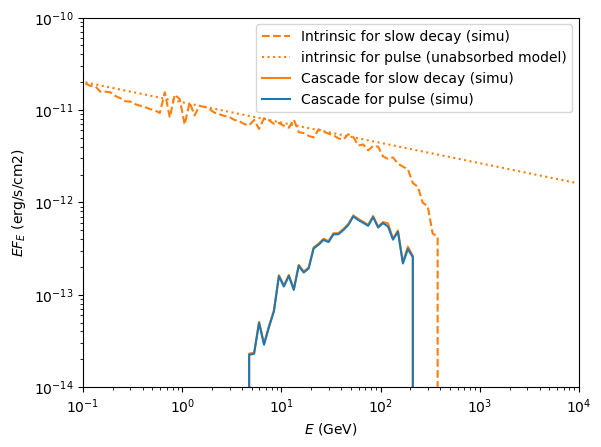

In [8]:
# SLOW DECAY -------------------------------------------------------------------------------
col = '#ff7f0e'

# Plot the spectrum of primary particles, as build from the simumation results
y = bd1.data[0,:]
plt.plot(e/GeV,e**2*y,ls='--',color=col,label='Intrinsic for slow decay (simu)')

# Overplot the average model in the same time window
plt.plot(e/GeV,e*model1.fe_ave(e,tmin,tmax,absorbed=False),color=col,
         label='intrinsic for pulse (unabsorbed model)',ls=':')

# Plot the spectrum of secondary particles (with gen>0), as build from the simulation results
y = np.sum(bd1.data[1:,:],axis=0)
plt.plot(e/GeV,e**2*y,color=col,label='Cascade for slow decay (simu)')


# PULSE ------------------------------------------------------------------------------------
col = '#1f77b4'

# Plot the spectrum of secondary particles (with gen>0), as build from the simulation results
y = np.sum(bd2.data[1:,:],axis=0)
plt.plot(e/GeV,e**2*y,color=col,label='Cascade for pulse (simu)')


plt.xscale("log")
plt.yscale("log")
plt.xlim(1.e-1,1.e4)
plt.ylim(1.e-14,1.e-10)
plt.xlabel(r'$E$ (GeV)')
plt.ylabel(r"$EF_E$ (erg/s/cm2)")
plt.legend()
plt.show()

# 3- Define multiple time bins
This example is quite similar to the previous one. But it defines several time bins instead of one unique time bin.

### 3a- Define the simulation to use

In [9]:
path = 'particles.csc'

### 3b- Read data, and apply selections

In [10]:
# Define energy and time ranges
emin, emax = 0.1*GeV,10*TeV
tmin, tmax = 10., 15*day
# read data and apply selection
rawdata = EventCatalog(filename=file,gen=[0,1,2,3],emin=emin,emax=emax,
                       tmax=tmax,thdmax=0.1*degree,chatter=False)

### 3c- Define bins, model and bin data

In [11]:
# Define unnormalized model
emodel = GRB130427A.emodel
tmodel = PulseTimeModel()
amodel = IsotropicAngularModel()
model = SourceModel(tmodel=tmodel,emodel=emodel, amodel=amodel)

# Normalize model so that the pulse fluence equals the fluence of GRB130427A integrated 
# in the 11.5-33s time band.
model.norm = GRB130427A.fe(1*TeV,t1=11.5,t2=33) / model.fe(1*TeV,0.,0.)

# energy bins
nbin = 40
eb = np.logspace(np.log10(emin),np.log10(emax),nbin+1)
e = 0.5*(eb[1:]+eb[:-1])

# time bins
nt = 6
tt = np.logspace(np.log10(tmin),np.log10(tmax),nt+1)

# Apply model and bin data
bd = BinnedData(rawdata,ebins=eb,tbins=tt,gbins=[0,1,2,3],smodel=model)


Binning Data
This might take a minute or so...
Done


### 3d- Plot spectra averages in all time bins

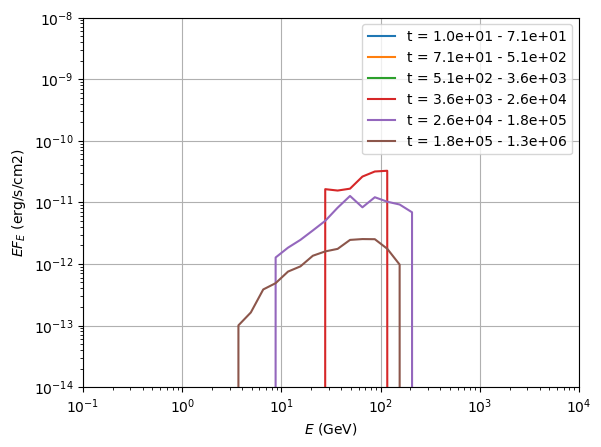

In [12]:
for it in range(nt):
    y = np.sum(bd.data[1:,it,:],axis=0)    
    plt.plot(e/GeV,e**2*y,label=f"t = {tt[it]:.1e} - {tt[it+1]:.1e}")

plt.xscale("log")
plt.yscale("log")
plt.xlim(1.e-1,1.e4)
plt.ylim(1.e-14,1.e-8)
plt.xlabel(r'$E$ (GeV)')
plt.ylabel(r"$EF_E$ (erg/s/cm2)")
plt.legend()
plt.grid()
plt.show()

# 4- Selecting a flux type
By default, the `BinnedData()`class builds histrogams in photon counts. This behaviour can be changed tu flux or sed with the `flx_type` argument. For small energy bins, this has no effect. However, when integreting over large enery bands, it makes a difference.

The following lines compare the results usng the three modes.


Binning Data
This might take a minute or so...
Done

Binning Data
This might take a minute or so...
Done

Binning Data
This might take a minute or so...
Done


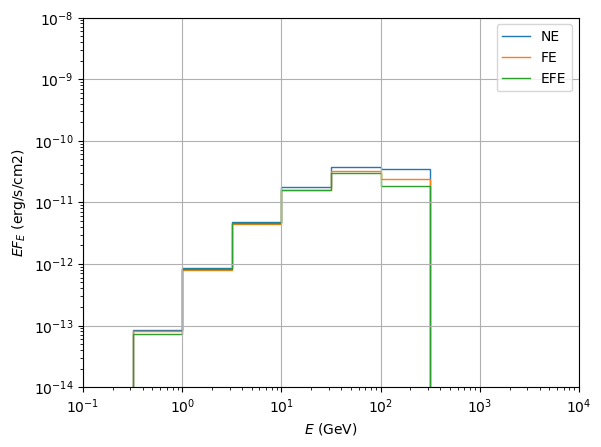

In [13]:
file =  'particles.csc'


# Define energy and time ranges
emin, emax = 0.1*GeV,10*TeV
tmin, tmax = 10., 15*day

# read data and apply selection
rawdata = EventCatalog(filename=file,gen=[0,1,2,3],emin=emin,emax=emax,
                       tmax=tmax,thdmax=0.1*degree,chatter=False)

smodel = GRB130427A

# energy bins
nbin = 10
eb = np.logspace(np.log10(emin),np.log10(emax),nbin+1)
e = 0.5*(eb[1:]+eb[:-1])

# time bins
tt = [1,1.e6]

# Using the default mode (photon counts)
bd = BinnedData(rawdata,ebins=eb,tbins=tt,gbins=[0,1,2,3],smodel=smodel,flx_type='NE')
y = np.sum(bd.data[1:,:],axis=0)
plt.stairs(e**2*y,eb/GeV,label="NE")

# Using the energy Flux mode
bd = BinnedData(rawdata,ebins=eb,tbins=tt,gbins=[0,1,2,3],smodel=smodel,flx_type='FE')
y = np.sum(bd.data[1:,:],axis=0)
plt.stairs(e*y,eb/GeV,label="FE")

# Using the SED mode
bd = BinnedData(rawdata,ebins=eb,tbins=tt,gbins=[0,1,2,3],smodel=smodel,flx_type='EFE')
y = np.sum(bd.data[1:,:],axis=0)
plt.stairs(y,eb/GeV,label="EFE")


plt.xscale("log")
plt.yscale("log")
plt.xlim(1.e-1,1.e4)
plt.ylim(1.e-14,1.e-8)
plt.xlabel(r'$E$ (GeV)')
plt.ylabel(r"$EF_E$ (erg/s/cm2)")
plt.legend()
plt.grid()
plt.show()

# 5- Checking the magnetic variance
For large magnetic coherence lengths, the cascade emission can depend on the specific realisation of the magnetic structure used in the simulation. Each MC simulation file actualy contains the results of `nBseed` different realisations of the magnetic structure. 

By default, the `BinnedData()` class returns the *median* flux. However, this behaviour can be changed using the `bmode` keyword to `mean` for the average, and `all` to return the array of results corresponding to all realisations. In latter case, the `data` attribute has one more dimension corresponding to the magnetic structure (with size `nBseed`). This is the leading dimension. 

The following plots the mean, median and some quantiles of the cascade spectrum due to the magnetic variance. Note that the observed uncertainty include not only the magnetic variance, but also the statistical variance of Monte-Carlo simulations.

Number of diffent magnetic strucure in the current simulation file: 100


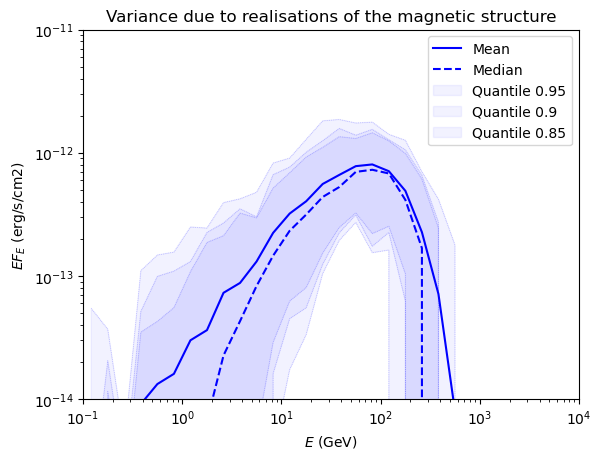

In [14]:
col = 'b'
z = 0.4245
B = 1.e-17
file = 'particles.csc'

# Define energy bins
emin, emax, nbin = 0.1 * GeV, 10 * TeV, 30
e, eb, de = grid(emin, emax, nbin, log=True)

# Define time range
tmin, tmax = 62., 62 + 30 * day

# Define source model
smodel = GRB190114C

# Read raw event catalog and apply some selections
evc = EventCatalog(filename=file, gen=[0, 1, 2, 3], emin=emin, emax=emax,
                       tmax=tmax, thdmax=0.1 * degree, chatter=0,exclude_field=('phip'))
print(f"Number of diffent magnetic strucure in the current simulation file: {evc.params['nBseed']}")

# Apply model and bin data using the bmode='all' keyword
bd = BinnedData(evc, ebins=eb, tbins=[tmin, tmax], gbins=[0, 1, 2, 3], bmode='all', smodel=smodel, chatter=0)
yy = np.sum(bd.data[:, 1:, :], axis=1) * e ** 2

# Plot average ----------------------------------------------------------------
yav = np.mean(yy, axis=0)
plt.plot(e / GeV, yav, color=col, label='Mean')

# Plot median -----------------------------------------------------------------
ymed = np.median(yy, axis=0)
plt.plot(e / GeV, ymed, color=col, ls='--',label='Median')

# Plot quantiles --------------------------------------------------------------
for q in [0.05, 0.10, .15]:
    ym = np.quantile(yy, q / 2, axis=0)
    yp = np.quantile(yy, 1. - q / 2, axis=0)
    plt.fill_between(e / GeV, ym, yp, color=col, alpha=0.05,label=f'Quantile {1-q}')
    plt.plot(e / GeV, ym, color=col, alpha=0.3, ls=':', lw=0.5)
    plt.plot(e / GeV, yp, color=col, alpha=0.3, ls=':', lw=0.5)

plt.xscale("log")
plt.yscale("log")
plt.xlim(1.e-1, 1.e4)
plt.ylim(1.e-14, 1.e-11)
plt.xlabel(r'$E$ (GeV)')
plt.ylabel(r"$EF_E$ (erg/s/cm2)")
plt.legend()
plt.title('Variance due to realisations of the magnetic structure')
plt.show()

# 6- Use a `NonSeparableSourceModel`
The class `NonSeparableSourceModel` allows to define source models where energy and time are not separable (that is with time-dependent spectral properties).

The following celles compare the cascades produced by models with separabale and non-separable
    time and energy.
    
Here, the array data used to build this model is actually separable in time and energy for check purposes. And both models yield similar results. However, any flux(energy,time) can be provided.

Both models are arbitrary normalised to a 1erg (EBL-absorbed) fluence in 100<E<300s and 0.3TeV<E<1TeV.

In [3]:
# Model properties
emin, emax = 1 * GeV, 30 * TeV
tmin, tmax = 10., 15 * day
z = 0.42

Binning for cascade observations

In [17]:
nbin = 30
eb = np.logspace(np.log10(emin), np.log10(emax), nbin + 1)
e = 0.5 * (eb[1:] + eb[:-1])
nt = 6
tt = np.logspace(np.log10(tmin), np.log10(tmax), nt + 1)

In [ ]:
# Read Event catalog from file
file = "./data/z042/particles_z0425_B1700_L600.csc"
EC = EventCatalog(filename=file, gen=[0, 1, 2, 3], emin=emin / 2, emax=10 * TeV,
                  tmax=2 * tmax, thdmax=0.1 * degree, chatter=0)

Define a first (separable) Model and bin

In [13]:
emodel = PowerLawSpectralModel(emin=emin, emax=emax, z=z)
tmodel = PowerLawTimeModel(tmin=tmin, tmax=tmax)
model1 = SourceModel(emodel=emodel, tmodel=tmodel)
model1.norm = 1.0 / model1.f(100, 300., 0.3 * TeV, 1 * TeV, absorbed=True)
bd1 = BinnedData(EC, ebins=eb, tbins=tt, gbins=[0, 1, 2, 3], smodel=model1)


Binning Data
This might take a minute or so...
Done


Setup grids that will define the NonSeparableSourceModel. 

Here, the grids used to define the non-separable model were chosen to match the model maximal/minimal times and energies. If not, the seperable and non-seperable models have a small difference proportional to the bin size.

In [14]:
egrid = np.logspace(np.log10(emin), np.log10(emax), 27)
tgrid = np.logspace(np.log10(tmin), np.log10(tmax), 25)
flux = np.zeros((len(egrid), len(tgrid)))
for it, t in enumerate(tgrid):
    flux[:, it] = model1.fet(egrid, t, absorbed=False)

Define NonSeparableSourceModel and bin cascade data

In [15]:
model2 = NonSeparableSourceModel(energy=egrid, time=tgrid, flux=flux, z=z)
model2.norm = 1.0 / model2.f(100, 300., 0.3 * TeV, 1 * TeV, absorbed=True)
#    time1 = time()
bd2 = BinnedData(EC, ebins=eb, tbins=tt, gbins=[0, 1, 2, 3], smodel=model2)


Binning Data
This might take a minute or so...
Done


Plot and compare results 

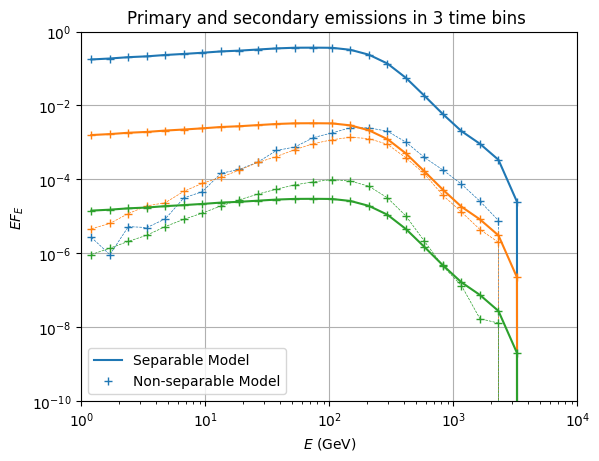

In [16]:
for it in range(0, nt, 2):
    label = 'Separable Model' if it == 0 else ''
    # For model 1
    pp = plt.plot(e / GeV, e ** 2 * bd1.data[0, it, :], ls='-', label=label)
    col = pp[0].get_color()
    plt.plot(e / GeV, e ** 2 * np.sum(bd1.data[1:, it, :], axis=0), ls='--', color=col, lw=0.5)
    # For model 2
    label = 'Non-separable Model' if it == 0 else ''
    plt.plot(e / GeV, e ** 2 * bd2.data[0, it, :], ls='', color=col, marker='+', label=label)
    plt.plot(e / GeV, e ** 2 * np.sum(bd2.data[1:, it, :], axis=0), color=col, marker='+', ls='', lw=0.5)
plt.xscale("log")
plt.yscale("log")
plt.xlim(1.e0, 1.e4)
plt.ylim(1.e-10, 1.e0)
plt.xlabel(r'$E$ (GeV)')
plt.ylabel(r"$EF_E$")
plt.title(f"Primary and secondary emissions in 3 time bins ")
plt.legend()
plt.grid()
plt.show()